In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import plotly
from PIL import Image
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from ipywidgets import interact
plotly.offline.init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from src.data.box import GravityHoleBall
from src.data.generate import generate_gravity_hole_ball_images

from src.utils.utils import add_spatial_encoding
from src.utils.node import  BatchGetterMultiImages, train_convnode_with_batch, train_convnode_with_batch_and_latent_supervision
from src.utils.viz import  display_convnode_trajectory

from src.models.convnode import ConvNodeWithBatch, ResNodeWithBatch#, LatentRegularizerLoss
from src.models.resnet import ResNetCustomEncoder, ResNetCustomDecoder
from src.models.anode import ANODENet

In [2]:
MARGIN_MIN = 7
MIN_INIT_VELOCITY = 1000.
WIDTH, HEIGHT = 28, 28
RADIUS = 3

# Gravity Hole

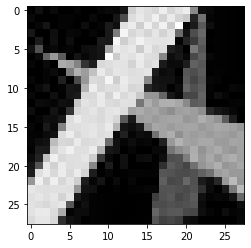

(0.92156863, 0.0)

In [3]:
# import a jpeg image 
background_image = Image.open('images/AE_ODE/Gravity/black_wallpaper.jpeg')
background_image = np.array(background_image)
background_image = background_image/255.
# transform to gray image
background_image = np.mean(background_image, axis=2)
# resize to 28x28
background_image = np.array(Image.fromarray(background_image).resize((28, 28)))
plt.imshow(background_image, cmap='gray')
plt.show()
background_image.max(), background_image.min()


In [4]:
infos = {
    "MARGIN_MIN":MARGIN_MIN,
    "MIN_INIT_VELOCITY":MIN_INIT_VELOCITY,
    "WIDTH":WIDTH,
    "HEIGHT":HEIGHT,
    "RADIUS":RADIUS
}

x = WIDTH/4.
y = HEIGHT/4.
vx = 0.
vy = 0.

box = GravityHoleBall(x, y, vx, vy, (WIDTH, HEIGHT),RADIUS)


Num_pos_velocity = 1
N = 30
N_frames = 300 + Num_pos_velocity
dt = 1./N_frames

times = np.arange(0, N_frames*dt, dt)

# encoded_trajectory = generate_gravity_hole_ball_positions(box, N=N, N_frames=N_frames, dt=dt)[:,:,:]
# print(encoded_trajectory.shape)
print("-"*50)
print("Generating images...")
images = generate_gravity_hole_ball_images(box, N=N, N_frames=N_frames, dt=dt, infos=infos, background_image=None).reshape(-1, 1, HEIGHT, WIDTH)
print(images.shape)
# dataset = [(image, 0) for image in dataset]
# dataset = add_spatial_encoding(dataset)
# print(len(dataset), len(dataset[0]), dataset[0][0].shape)
images = torch.from_numpy(add_spatial_encoding(images)).float().reshape(N, -1, 3, HEIGHT, WIDTH)
print(images.shape)


--------------------------------------------------
Generating images...


  0%|          | 0/30 [00:00<?, ?it/s]/users/eleves-b/2019/maxime.bonnin/perso/IntNeuralODE/src/data/generate.py:108: RuntimeWarning:

invalid value encountered in true_divide

100%|██████████| 30/30 [00:01<00:00, 16.17it/s]


(9030, 1, 28, 28)
torch.Size([30, 301, 3, 28, 28])


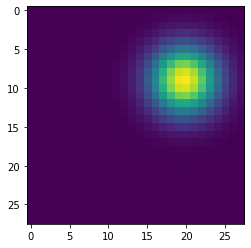

In [5]:
plt.imshow(images[0,0,0])

In [6]:
print(images[0,0,0, 5,0], images[0,0,0, 0,3], images[0,0,0, 5,5]  )

tensor(1.7108e-10) tensor(1.9793e-09) tensor(2.4371e-06)


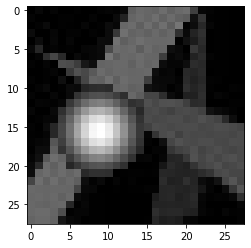

In [7]:
ball_img = images[1,0,0]
ball_img = (ball_img - ball_img.min())/(ball_img.max() - ball_img.min())
ball_img = np.where(ball_img > 0.15, ball_img, 0.5*background_image)
# img = 0.1*background_image + 0.9*images[0,0,0].numpy()
ball_img = (ball_img - ball_img.min())/(ball_img.max() - ball_img.min())

plt.imshow(ball_img, cmap='gray')



# Moving MNIST

In [3]:
print("-"*50)
print("Generating images...")
images = np.load("data/movingmnist_dataset_10000_30_1_2/sequences.npy").swapaxes(-1,-2)
# images = np.load("data/mnist_test_seq_resized.npy").swapaxes(0,1)
print(images.shape)
shape = images.shape

images = images.reshape(-1, 1, shape[-2], shape[-1])
print(images.shape)
N = shape[0]
N_frames = shape[1]
dt = 1./N_frames
Num_pos_velocity = 1
times = np.arange(0, N_frames*dt, dt)

# dataset = [(image, 0) for image in dataset]
# dataset = add_spatial_encoding(dataset)
# print(len(dataset), len(dataset[0]), dataset[0][0].shape)
images = torch.from_numpy(add_spatial_encoding(images)).float().reshape(N, -1, 3, HEIGHT, WIDTH)

# split the dataset
images_train, images_test = train_test_split(images, test_size=0.2, random_state=42)

print(images_train.shape, images_test.shape)
print(images.max(), images.min())

--------------------------------------------------
Generating images...
(10000, 30, 28, 28)
(300000, 1, 28, 28)
torch.Size([8000, 30, 3, 28, 28]) torch.Size([2000, 30, 3, 28, 28])
tensor(1.) tensor(0.)


In [4]:
class TimeDistributed(nn.Module):
    def __init__(self, module, len_shape_without_batch, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self._len_shape_without_batch = len_shape_without_batch
        self.batch_first = batch_first

    def forward(self, x):
        # x: [batch, time, *]
        assert len(x.shape) == self._len_shape_without_batch or self._len_shape_without_batch + 1, f"Input must have shape {self._len_shape_without_batch}D or {self._len_shape_without_batch + 1}D, received {len(x.shape)}D"

        if len(x.size()) == self._len_shape_without_batch:
            return self.module(x)

        batch_flatten_shapes = list(x.shape[1:])
        batch_flatten_shapes[0] = -1
        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().reshape(batch_flatten_shapes)  # (samples * timesteps, input_size)
        # print("TimeDistributed: x_reshape: ", x_reshape.shape)
        y = self.module(x_reshape)
        # print("TimeDistributed: y: ", y.shape)

        # We have to reshape Y
        
        if self.batch_first:
            final_shapes = [x.shape[0], -1] + list(y.shape[1:])
            y = y.contiguous().view(final_shapes)  # (samples, timesteps, output_size)
        else:
            final_shapes = [-1, x.shape[1]] + list(y.shape[1:])
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)
        # print("TimeDistributed: y return: ", y.shape)


        # print('TimeDistributed: y return: ', y.shape)    
        return y


class ResNodeWithBatch(nn.Module):
    def __init__(self, device, size, latent_dim, in_channels, layers,
    ode_hidden_dim, ode_out_dim, augment_dim=0, time_dependent=False, ode_linear_layer=False,
    ode_non_linearity='relu', conv_activation=nn.ReLU(),latent_activation=None, stack_size=1):
    
        super(ResNodeWithBatch, self).__init__()
        self.device = device
        self.size = size
        self.latent_dim = latent_dim
        self.in_channels = in_channels
        self.layers = layers
        self.conv_activation = conv_activation
        self.latent_activation = latent_activation
        self.ode_hidden_dim = ode_hidden_dim
        self.out_dim = ode_out_dim
        self.augment_dim = augment_dim
        self.time_dependent = time_dependent
        self.ode_linear_layer = ode_linear_layer
        self.ode_non_linearity = ode_non_linearity

        print("-"*50)
        print("Creating ConvAE...")
        self.encoder = TimeDistributed(
            ResNetCustomEncoder(layers, in_channels, n_latent=latent_dim, expansion=4)
            .to(device),
            len_shape_without_batch=4, # input without batch are (times, latent_dim)
            batch_first=True
        )
        self.decoder = TimeDistributed(
            ResNetCustomDecoder(img_channel=in_channels, n_latent=latent_dim).to(device),
            len_shape_without_batch=2, # input without batch are (times, latent_dim)
            batch_first=True
        )

        print("-"*50)
        print("Creating ANODENet...")
        self.node = ANODENet(device, latent_dim*(stack_size + 1), ode_hidden_dim, ode_out_dim, augment_dim, time_dependent=False,
            non_linearity=ode_non_linearity, linear_layer=ode_linear_layer).to(device)

    def forward(self, images, times, dt):
        # images: [(batch), n_stack, in_channels, height, width]
        # latent_z: [n_stack, latent_dim]
        # print("input_images: ", images.shape)
        latent_z = self.encoder(images)
        # print("latent_z: ", latent_z.shape)
        
        # latent_z_stack: [(batch), n_stack, latent_dim*(n_stack+1)]
        # for the moment n_stack = 1
        if len(latent_z.shape) == 3:
            latent_z_stack = torch.cat([latent_z[:, :-1], (latent_z[:, 1:]-latent_z[:, :-1])/dt], dim=-1).squeeze(1)
        

        elif len(latent_z.shape) == 2:
            latent_z_stack = torch.cat([latent_z[:-1], (latent_z[1:]-latent_z[:-1])/dt], dim=-1)

        # print("latent_z_stack: ", latent_z_stack.shape)

        # sim : [times, (batch),ode_out_dim]
        sim = self.node(latent_z_stack, times)
        # print("sim: ", sim.shape)
        # sim : [(batch), n_stack, ode_out_dim]
        if len(images.shape) == 5:
            sim = sim.swapdims(0,1)
        else:
            sim = sim.squeeze(1)
        # print("sim: ", sim.shape)

        reconstructed_images = self.decoder(sim)
        # print("reconstructed_images: ", reconstructed_images.shape)

        return reconstructed_images, sim

    def encode(self, images):

        return self.encoder(images)

    def decode(self, latent_z):
        return self.decoder(latent_z)

# Model

In [5]:
print("-"*50)
print("Creating model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
size = 28
latent_dim = 128
in_channels = 3
layers = [3, 4, 6, 3]
ode_data_dim = latent_dim
ode_hidden_dim = 256
augment_dim = 0
time_dependent=False
ode_non_linearity='relu' 
conv_activation=nn.ReLU()
latent_activation=None
stack_size=1

# conv_ode = ConvNodeWithBatch(device, size, latent_dim, in_channels,
#     ode_hidden_dim, ode_data_dim, augment_dim=augment_dim, time_dependent=time_dependent,
#     ode_non_linearity=ode_non_linearity, ode_linear_layer=False, conv_activation=conv_activation,
#     latent_activation=latent_activation, stack_size=stack_size)

conv_ode = ResNodeWithBatch(device, size, latent_dim, in_channels, layers,
    ode_hidden_dim, ode_data_dim, augment_dim=augment_dim, time_dependent=time_dependent,
    ode_non_linearity=ode_non_linearity, ode_linear_layer=False, conv_activation=conv_activation,
    latent_activation=latent_activation, stack_size=stack_size)


# pathConvODE = "models/AE_ODE/ConvODE/conv_ode_1_ball_latent_{}_hidden_ode_{}_stack_{}_conv_activation_{}_with_lambda_decay.pt".format(latent_dim, ode_hidden_dim, stack_size, conv_activation)
# pathConvODE = "ssh/conv_ode_1_ball_latent_32_hidden_ode_128_stack_1_conv_activation_ReLU()_with_lambda_decay_together.pt"
# pathConvODE = "ssh/conv_ode_1_ball_latent_32_hidden_ode_128_stack_1_conv_activation_ReLU()_with_lambda_decay_ODE_and_decoder.pt"
# # pathConvODE = "conv_ode_1_ball_latent_10_hidden_ode_128_stack_1_conv_activation_ReLU()_with_lambda_decay_together_v2.pt"
# pathConvODE = "conv_ode_1_ball_latent_16_hidden_ode_128_stack_1_conv_activation_ReLU()_last_model_with_background.pt"

# pathConvODE = "ssh/conv_ode_moving_mnist_latent_128_hidden_ode_256_stack_1_conv_activation_ReLU()_last_model.pt"
# pathConvODE = "ssh/conv_ode_moving_mnist_latent_128_hidden_ode_256_stack_1_conv_activation_ReLU()_last_model.pt"
# pathConvODE = "ssh/conv_ode_moving_mnist_latent_128_hidden_ode_128_stack_1_conv_activation_ReLU()_last_model_for_comparison.pt"
# pathConvODE = "ssh/resnet_ode_moving_mnist_latent_{}_hidden_ode_{}_stack_{}_conv_activation_{}_last_model_for_comparison.pt".format(latent_dim, ode_hidden_dim, stack_size, conv_activation)
pathConvODE = "ssh/resnet_ode_one_digit_moving_mnist_latent_128_hidden_ode_256_stack_1_conv_activation_ReLU()_last_model.pt"
print(conv_ode.load_state_dict(torch.load(pathConvODE, map_location=device)))

--------------------------------------------------
Creating model...
--------------------------------------------------
Creating ConvAE...
----------------------------------------------------------------------
Number of parameters:  0.408896 M
----------------------------------------------------------------------
Number of parameters in decoder:  0.497075 M
--------------------------------------------------
Creating ANODENet...
Number of parameters in the model: 230272
<All keys matched successfully>


In [6]:
print("-"*50)
print("Creating tools to train...")
batch_size = 64
batch_time = 28
n_stack = 1
total_length = N_frames - Num_pos_velocity

getter = BatchGetterMultiImages(batch_time, batch_size, n_stack, total_length, dt, images_train, frac_train=1.)

--------------------------------------------------
Creating tools to train...


In [7]:
res = getter.get_batch()
print(res[0].shape)
print(res[1].shape)
print(res[2].shape)

torch.Size([64, 2, 3, 28, 28])
torch.Size([28])
torch.Size([64, 28, 3, 28, 28])


# Loss without latent supervision

In [8]:
from src.models.convnode import TimeDistributed

class LatentRegularizerLoss(nn.Module):
    def __init__(self, device, reg_lambda, step_decay=1, decay_rate=0.9, weighted=False, image_loss=None):
        super(LatentRegularizerLoss, self).__init__()
        self.device = device
        self.reg_lambda = reg_lambda

        if image_loss is None:
            self.image_loss = nn.MSELoss()

        elif not isinstance(image_loss, nn.Module):
            raise ValueError("reconstruction_loss must be a subclass of nn.Module")
            
        else:
            self.image_loss = image_loss

        if weighted:
            self.image_loss.__init__(reduction="none")
        else:
            self.image_loss.__init__(reduction="mean")
        
        self.step_decay = step_decay
        self.decay_rate = decay_rate
        self._step = 0
        self.weighted = weighted

    def forward(self, latent_z, pred_images, true_images):
        # latent_z: [batch, latent_dim]
        # pred_images: [batch, n_stack, in_channels, height, width]
        # true_images: [batch, n_stack, in_channels, height, width]
        loss_img = self.image_loss(pred_images, true_images)
        # print(loss_img.shape)
        if self.weighted:
            weights = torch.linspace(0, 1, pred_images.shape[1]).to(device).repeat(loss_img.shape[0], 1)
            # print(weights.shape)
            # print(weights.shape)
            # print(weights)
            weights = (0.0 + 5 * weights)
            # print(weights)
            loss_img = loss_img.mean(dim=(2,3,4))*weights 
        loss_img = loss_img.mean(dim=-1).mean(dim=-1)

        loss_reg = torch.linalg.norm(latent_z, ord=2, dim=-1).mean(dim=-1).mean(dim=-1)
        # print("loss_img: ", loss_img)
        # print("loss_reg: ", loss_reg)
        return loss_img + self.reg_lambda * loss_reg
    

    def step(self):
        self._step +=1
        if self._step % self.step_decay == 0:
            self.reg_lambda *= self.decay_rate
            

    def forward_print(self, latent_z, pred_images, true_images):
        # latent_z: [batch, latent_dim]
        # pred_images: [batch, n_stack, in_channels, height, width]
        # true_images: [batch, n_stack, in_channels, height, width]
        loss_img = self.image_loss(pred_images, true_images)

        if self.weighted:
            weights = torch.linspace(0, 1, pred_images.shape[1]).to(device).repeat(loss_img.shape[0], 1)
            # print(weights.shape)
            # print(weights.shape)
            # print(weights)
            weights = (0.1 + 2 * weights)
            # print(weights)
            loss_img_weighted = loss_img.mean(dim=(2,3,4))*weights 
            loss_img = loss_img.mean(dim=(2,3,4))

        loss_reg = torch.linalg.norm(latent_z, ord=2, dim=-1).mean(dim=-1).mean(dim=-1)
        print("-"*30, "Loss prints", "-"*30)
        print("loss_img unweighted: ", loss_img.mean(dim=-1).mean(dim=-1))
        if self.weighted:
            print("loss_img weighted: ", loss_img_weighted.mean(dim=-1).mean(dim=-1))
        print("loss_reg: ", self.reg_lambda * loss_reg)
        print("reg_lambda: ",self.reg_lambda)
        print("-"*73)
        return None

class FinalStateWeightingMSE(nn.Module):
    def __init__(self):
        super(FinalStateWeightingMSE, self).__init__()
        # self.mse = TimeDistributedLoss(nn.MSELoss(),
        #                     4
        # )

        self.mse = nn.MSELoss(reduction="none")
        
    def forward(self, latent_z, pred_images, true_images):
        # latent_z: [batch, latent_dim]
        # pred_images: [batch, n_stack, in_channels, height, width]
        # true_images: [batch, n_stack, in_channels, height, width]
        loss_img = self.mse(pred_images, true_images).mean(dim=(2,3,4))
        # print(loss_img.shape)
        weights = torch.linspace(0, 1, pred_images.shape[1]).to(device).repeat(loss_img.shape[0], 1)
        # print(weights.shape)
        # print(weights)
        weights = (0.0 + 5 * weights)
        # print(weights)
        loss_img = loss_img*weights
        # print(loss_img)
        return loss_img.mean(dim=-1).mean(dim=-1)

    def step(self):
        pass

    def forward_print(self, latent_z, pred_images, true_images):
        loss_img = self.mse(pred_images, true_images).mean(dim=(2,3,4))
        # print(loss_img.shape)
        weights = torch.linspace(0, 1, pred_images.shape[1]).to(device).repeat(loss_img.shape[0], 1)
        # print(weights.shape)
        # print(weights)
        weights = (0.1 + 2 * weights)
        # print(weights)
        loss_img_weighted = loss_img*weights
        # print(loss_img)
        print("-"*30, "Loss prints", "-"*30)
        print("loss_img unweighted: ", loss_img.mean(dim=-1).mean(dim=-1))
        print("loss_img weighted: ", loss_img_weighted.mean(dim=-1).mean(dim=-1))
        print("-"*73)
        return loss_img_weighted.mean(dim=-1).mean(dim=-1), loss_img.mean(dim=-1).mean(dim=-1)


optimizerEnc = torch.optim.Adam(conv_ode.encoder.parameters(), lr=1e-5)
optimizerDec = torch.optim.Adam(conv_ode.decoder.parameters(), lr=1e-5)
optimizerODE = torch.optim.Adam(conv_ode.node.parameters(), lr=3e-5) #1e-4)
optimizers = [optimizerEnc, optimizerDec, optimizerODE]
scheduler = torch.optim.lr_scheduler.StepLR(optimizerODE, step_size=5000, gamma=1.)

reg_lambda = 1e-5
loss_fn = LatentRegularizerLoss(device, reg_lambda, step_decay=3000, decay_rate=1.0, weighted=True, image_loss=nn.MSELoss())
# 4.722366482869652e-05
# Adam (
# Parameter Group 0
#     amsgrad: False
#     betas: (0.9, 0.999)
#     eps: 1e-08
#     initial_lr: 0.0001
#     lr: 1.667718169966658e-05
#     weight_decay: 0
# )


In [9]:
# loss_fn = FinalStateWeightingMSE()
inputs = torch.zeros(3, 10, in_channels, size, size).to(device)
outputs = torch.zeros(3, 10, in_channels, size, size).to(device)
latent_z = torch.zeros(1)
loss_fn(latent_z, inputs, outputs)
loss_fn.forward_print(latent_z, inputs, outputs)

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0., device='cuda:0')
loss_img weighted:  tensor(0., device='cuda:0')
loss_reg:  tensor(0.)
reg_lambda:  1e-05
-------------------------------------------------------------------------


# Loss with latent supervision

In [25]:
class LatentRegularizerLossWithLatent(nn.Module):
    def __init__(self, device, reg_lambda, latent_lambda, step_decay=1, decay_rate=0.9, weighted=False):
        super(LatentRegularizerLossWithLatent, self).__init__()
        self.device = device
        self.reg_lambda = reg_lambda
        self.latent_lambda = latent_lambda
        
        if weighted:
            self.image_loss = nn.MSELoss(reduction="none")
        else:
            self.image_loss = nn.MSELoss()
        
        self.step_decay = step_decay
        self.decay_rate = decay_rate
        self._step = 0
        self.weighted = weighted

    def forward(self, pred_latent, true_latent, pred_images, true_images):
        # latent_z: [batch, latent_dim]
        # pred_images: [batch, n_stack, in_channels, height, width]
        # true_images: [batch, n_stack, in_channels, height, width]
        loss_img = self.image_loss(pred_images, true_images)
        loss_latent = self.image_loss(pred_latent, true_latent)
        # print(loss_img.shape)
        if self.weighted:
            weights = torch.linspace(0, 1, pred_images.shape[1]).to(device).repeat(loss_img.shape[0], 1)
            # print(weights.shape)
            # print(weights.shape)
            # print(weights)
            weights = (0.0 + 5 * weights)
            # print(weights)
            loss_img = loss_img.mean(dim=(2,3,4))*weights 

            loss_latent = loss_latent.mean(dim=-1)*weights

        loss_img = loss_img.mean(dim=-1).mean(dim=-1)

        loss_latent = loss_latent.mean(dim=-1).mean(dim=-1)

        loss_reg = torch.linalg.norm(true_latent, ord=2, dim=-1).mean(dim=-1).mean(dim=-1)
        # print("loss_img: ", loss_img)
        # print("loss_reg: ", loss_reg)
        return loss_img + self.reg_lambda * loss_reg + self.latent_lambda*loss_latent
    

    def step(self):
        self._step +=1
        if self._step % self.step_decay == 0:
            self.reg_lambda *= self.decay_rate
            

    def forward_print(self, pred_latent, true_latent, pred_images, true_images):
        # latent_z: [batch, latent_dim]
        # pred_images: [batch, n_stack, in_channels, height, width]
        # true_images: [batch, n_stack, in_channels, height, width]
        loss_img = self.image_loss(pred_images, true_images)
        loss_latent = self.image_loss(pred_latent, true_latent)

        if self.weighted:
            weights = torch.linspace(0, 1, pred_images.shape[1]).to(device).repeat(loss_img.shape[0], 1)
            # print(weights.shape)
            # print(weights.shape)
            # print(weights)
            weights = (0.1 + 2 * weights)
            # print(weights)
            loss_img_weighted = loss_img.mean(dim=(2,3,4))*weights 
            loss_img = loss_img.mean(dim=(2,3,4))

            loss_latent_weighted = loss_latent.mean(dim=-1)*weights
            loss_latent = loss_latent.mean(dim=-1)
        


        

        loss_reg = torch.linalg.norm(true_latent, ord=2, dim=-1).mean(dim=-1).mean(dim=-1)
        print("-"*30, "Loss prints", "-"*30)
        print("loss_img unweighted: ", "{:.6f}".format(loss_img.mean(dim=-1).mean(dim=-1).item()))
        if self.weighted:
            print("loss_img weighted: ", "{:.6f}".format((loss_img_weighted.mean(dim=-1).mean(dim=-1)).item()))

        print("loss_latent unweighted: ", "{:.6f}".format((self.latent_lambda*loss_latent.mean(dim=-1).mean(dim=-1)).item()))
        if self.weighted:
            print("loss_latent weighted: ", "{:.6f}".format((self.latent_lambda*loss_latent_weighted.mean(dim=-1).mean(dim=-1)).item()))
        print("loss_reg: ", "{:.6f}".format((self.reg_lambda * loss_reg).item()))
        print("reg_lambda: ","{:.6f}".format((self.reg_lambda)))
        print("-"*73)
        return None

reg_lambda = 0 #5e-3
latent_lambda = 5
loss_fn = LatentRegularizerLossWithLatent(device, reg_lambda, latent_lambda, step_decay=3000, decay_rate=0.8, weighted=False)

In [26]:
# loss_fn = FinalStateWeightingMSE()
inputs = torch.randn(3, 10, in_channels, size, size).to(device)
outputs = torch.randn(3, 10, in_channels, size, size).to(device)
pred_latent = torch.randn(3, 10, 2).to(device)
true_latent = torch.randn(3, 10, 2).to(device)

print(loss_fn(pred_latent, true_latent, inputs, outputs))
loss_fn.forward_print(pred_latent, true_latent, inputs, outputs)

tensor(8.8419, device='cuda:0')
------------------------------ Loss prints ------------------------------
loss_img unweighted:  1.994807
loss_latent unweighted:  6.847097
loss_reg:  0.000000
reg_lambda:  0.000000
-------------------------------------------------------------------------


# Training process

In [10]:
root = None #"images/AE_ODE/Gravity/MultiTrajectories/Together/"
name = None # "conv_ode_1_ball_latent_{}_hidden_ode_{}_stack_{}_conv_activation_{}".format(latent_dim, ode_hidden_dim, stack_size, conv_activation)
display_fn = lambda i, model, out_display, getter, final_time, dt: display_convnode_trajectory(i, model, out_display, getter, final_time, dt, root=root, name=name)
# display_fn(0, conv_ode, latent_dim, getter, N_frames - Num_pos_velocity, dt)

## Training with latent supervision

In [11]:
optimizer = torch.optim.Adam(conv_ode.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.9)

--------------------------------------------------
Training...


  1%|          | 499/50000 [01:10<1:59:34,  6.90it/s, Loss: 0.01213414]

The graphs at epoch 500


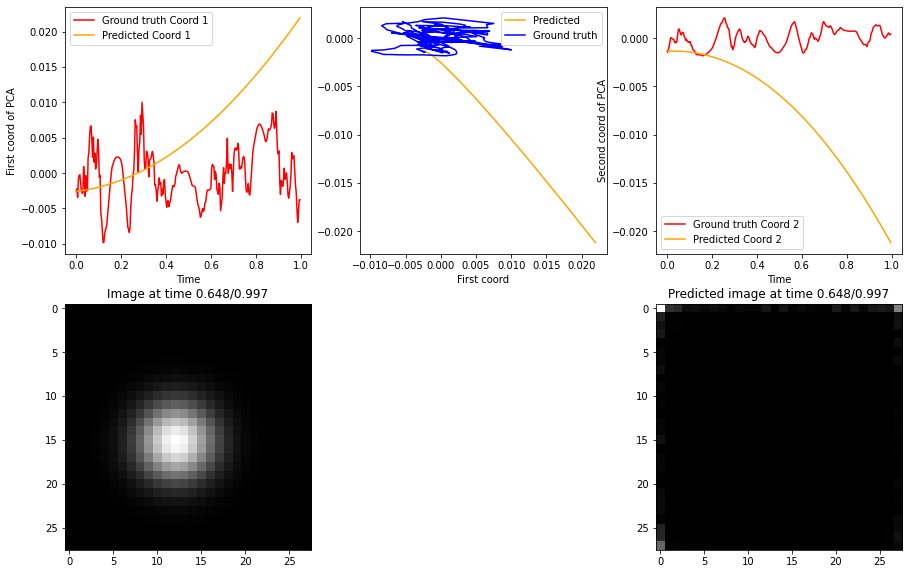

Display loss: 0.03165094:   1%|          | 501/50000 [01:11<3:25:13,  4.02it/s, Loss: 0.01109493]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  0.012119
loss_latent unweighted:  0.000015
loss_reg:  0.000000
reg_lambda:  0.000000
-------------------------------------------------------------------------


Display loss: 0.03165094:   2%|▏         | 999/50000 [02:22<1:56:09,  7.03it/s, Loss: 0.01155081]

The graphs at epoch 1000


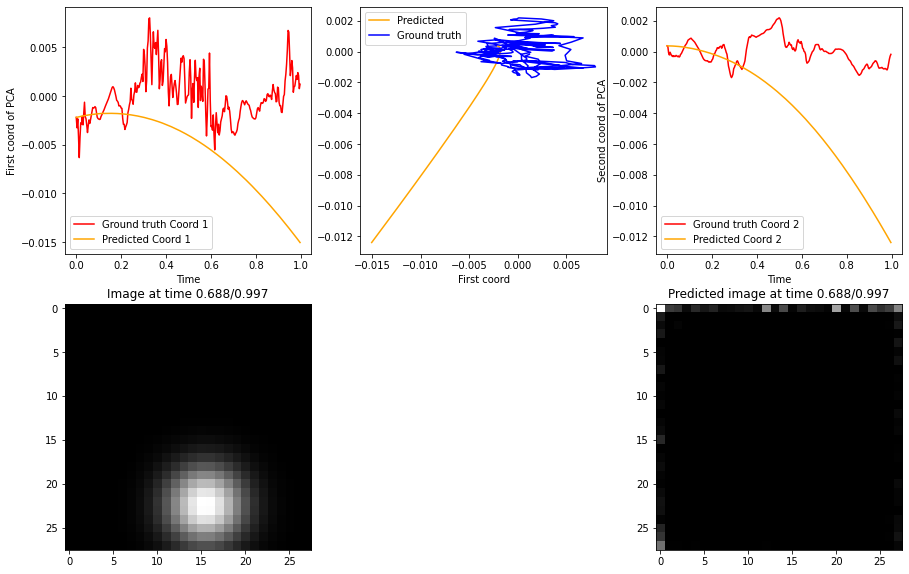

Display loss: 0.01127540:   2%|▏         | 1001/50000 [02:23<3:20:13,  4.08it/s, Loss: 0.01143022]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  0.011544
loss_latent unweighted:  0.000007
loss_reg:  0.000000
reg_lambda:  0.000000
-------------------------------------------------------------------------


Display loss: 0.01127540:   2%|▏         | 1141/50000 [02:43<1:56:41,  6.98it/s, Loss: 0.01146191]


KeyboardInterrupt: 

In [95]:
print("-"*50)
print("Training...")
epochs = 50000

# for param in conv_ode.node.parameters():
#     param.requires_grad = True
    
train_convnode_with_batch_and_latent_supervision(conv_ode, optimizer, scheduler, epochs,
    getter, loss_fn=loss_fn, display=500, display_results_fn=display_fn)

## Training without latent supervision

--------------------------------------------------
Training...


  2%|▏         | 999/50000 [02:14<1:31:20,  8.94it/s, Loss: 0.00693539]

The graphs at epoch 1000


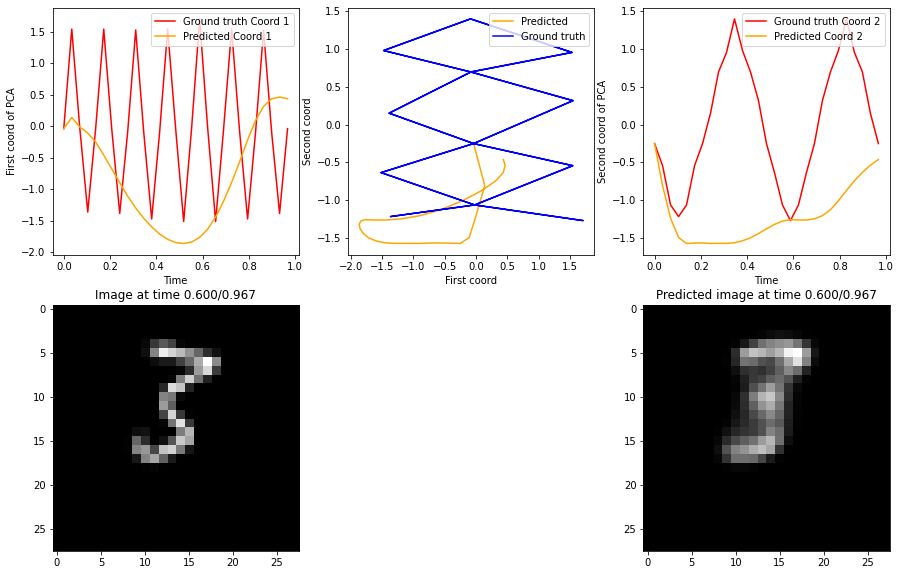

Display loss: 0.00675346:   2%|▏         | 1001/50000 [02:15<3:02:40,  4.47it/s, Loss: 0.00740463]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0031, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0030, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0.0001, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  1e-05
-------------------------------------------------------------------------


Display loss: 0.00675346:   4%|▍         | 1999/50000 [04:32<1:50:18,  7.25it/s, Loss: 0.00637573]

The graphs at epoch 2000


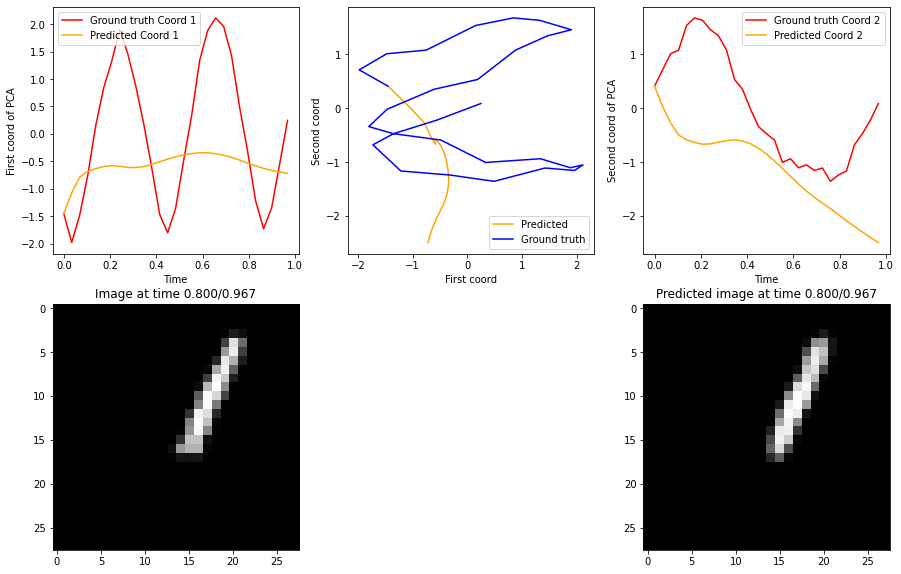

Display loss: 0.00675634:   4%|▍         | 2001/50000 [04:33<3:26:13,  3.88it/s, Loss: 0.00708948]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0029, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0028, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0.0001, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  1e-05
-------------------------------------------------------------------------


Display loss: 0.00675634:   6%|▌         | 2999/50000 [06:50<1:55:17,  6.79it/s, Loss: 0.00679709]

The graphs at epoch 3000


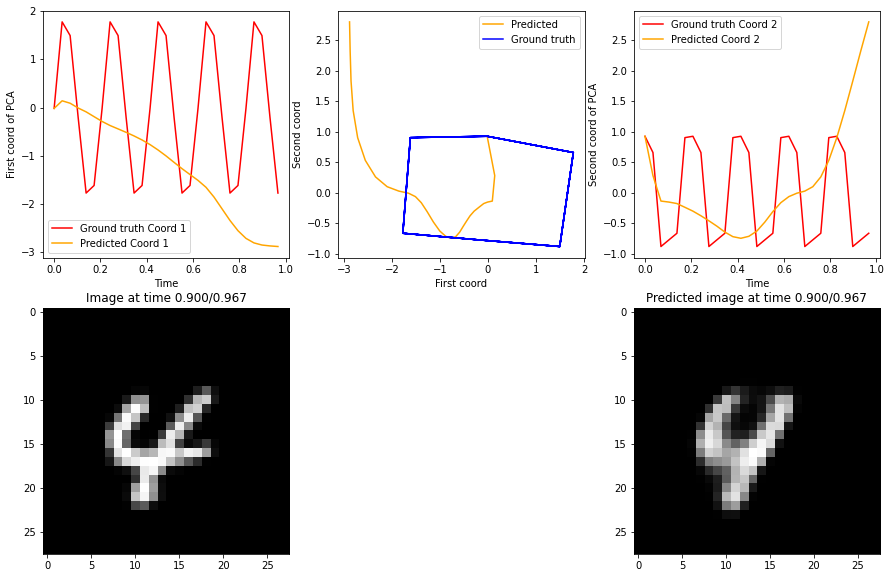

Display loss: 0.00673832:   6%|▌         | 3001/50000 [06:51<3:40:19,  3.56it/s, Loss: 0.00689237]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0031, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0030, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0.0001, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  1e-05
-------------------------------------------------------------------------


Display loss: 0.00673832:   8%|▊         | 3999/50000 [09:08<1:46:19,  7.21it/s, Loss: 0.00797254]

The graphs at epoch 4000


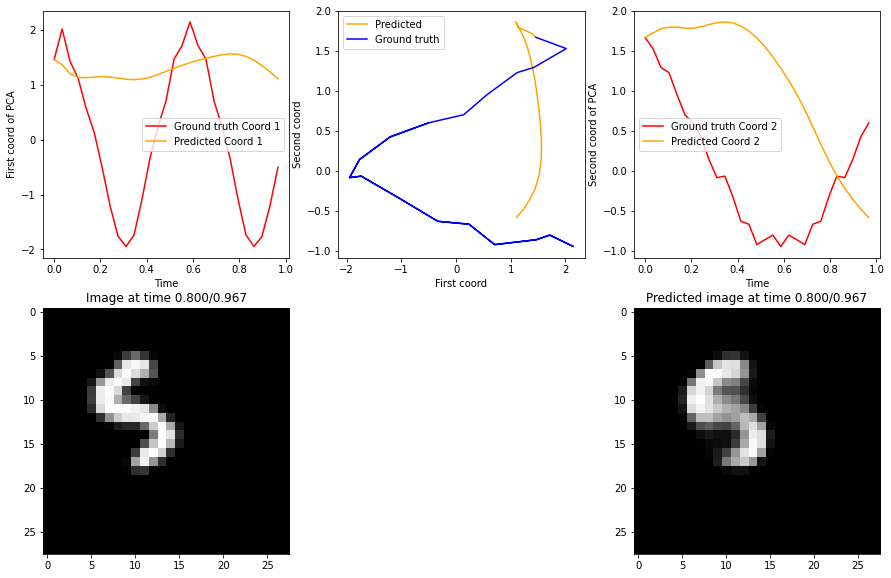

Display loss: 0.00672691:   8%|▊         | 4001/50000 [09:09<3:25:57,  3.72it/s, Loss: 0.00651148]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0035, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0035, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(9.9316e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  1e-05
-------------------------------------------------------------------------


Display loss: 0.00672691:  10%|▉         | 4999/50000 [11:26<1:43:40,  7.23it/s, Loss: 0.00660440]

The graphs at epoch 5000


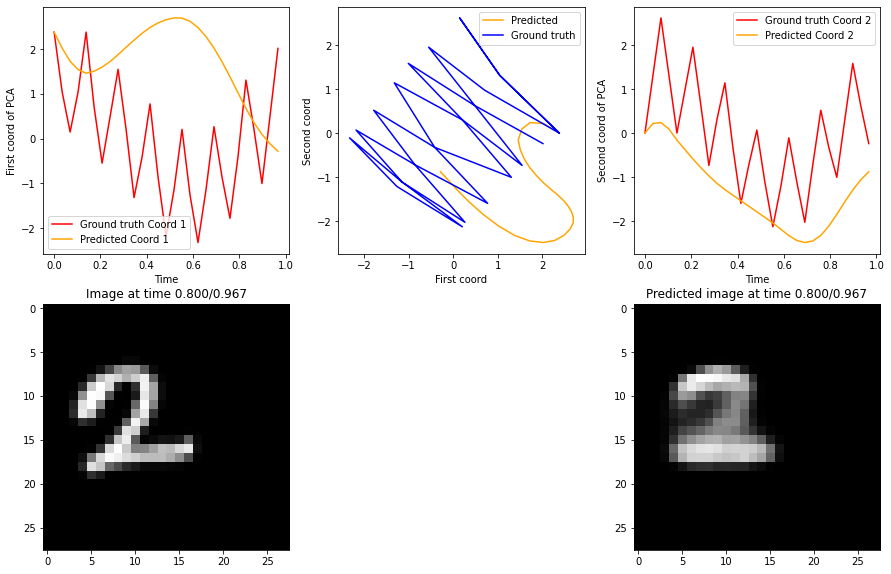

Display loss: 0.00669717:  10%|█         | 5001/50000 [11:26<3:13:09,  3.88it/s, Loss: 0.00652835]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0030, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0029, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0.0001, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  1e-05
-------------------------------------------------------------------------


Display loss: 0.00669717:  12%|█▏        | 5999/50000 [13:44<1:37:11,  7.55it/s, Loss: 0.00624496]

The graphs at epoch 6000


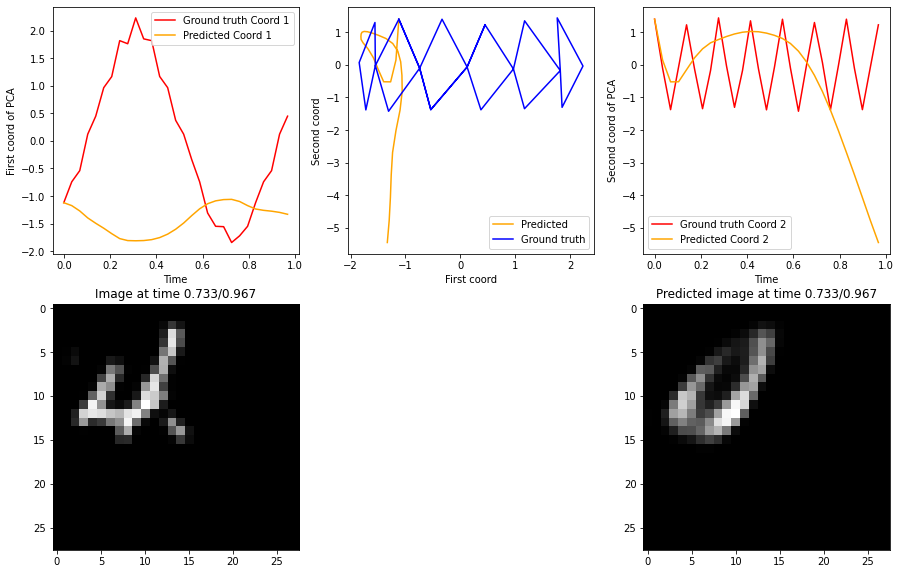

Display loss: 0.00671732:  12%|█▏        | 6001/50000 [13:45<3:07:32,  3.91it/s, Loss: 0.00655575]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0028, device='cuda:0', grad_fn=<MeanBackward1>)
loss_img weighted:  tensor(0.0027, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(0.0001, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  1e-05
-------------------------------------------------------------------------


Display loss: 0.00671732:  13%|█▎        | 6360/50000 [14:34<1:40:03,  7.27it/s, Loss: 0.00698521]


KeyboardInterrupt: 

In [11]:
print("-"*50)
print("Training...")
epochs = 50000

# for param in conv_ode.node.parameters():
#     param.requires_grad = True


train_convnode_with_batch(conv_ode, optimizers, scheduler, epochs,
    getter, loss_fn=loss_fn, display=1000, display_results_fn=display_fn)

In [12]:
pathConvODE = "ssh/resnet_ode_one_digit_moving_mnist_latent_{}_hidden_ode_{}_stack_{}_conv_activation_{}_last_model.pt".format(latent_dim, ode_hidden_dim, stack_size, conv_activation)
torch.save(conv_ode.state_dict(), pathConvODE)

In [ ]:
print("-"*50)
print("Training...")
for param in conv_ode.encoder.parameters():
    param.requires_grad = False

for param in conv_ode.decoder.parameters():
    param.requires_grad = False

# loss_fn.reg_lambda = 0.
optimizer = torch.optim.Adam(conv_ode.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.9)

epochs = 30000
train_convnode_with_batch(conv_ode, optimizer, scheduler, epochs,
    getter, loss_fn=loss_fn, display=1000, display_results_fn=display_fn)

In [28]:
pathConvODE = "conv_ode_1_ball_latent_{}_hidden_ode_{}_stack_{}_conv_activation_{}_with_lambda_decay_ODE_and_decoder_new_loss_sep_and_jointly.pt".format(latent_dim, ode_hidden_dim, stack_size, conv_activation)
torch.save(conv_ode.state_dict(), pathConvODE)

In [13]:
from skimage.color import gray2rgb

def generate_interactive_plot(i, model, out_display, getter, final_time, dt, root=None, name=None):

    index = np.random.randint(0, getter.N_train)
    time_steps = np.linspace(0, final_time*dt, final_time)

    times = torch.arange(0, final_time*dt, dt)

    gd_images = getter.train_images[index, :-1][:,0].cpu().numpy()
    input_images = getter.train_images[index, :2]
    model.eval()
    with torch.no_grad():
        reconstructed_images, _ = model(input_images.to(device), times.to(device), dt)
        reconstructed_images = reconstructed_images.cpu().numpy()

    print("Sim", reconstructed_images.shape, gd_images.shape)

    gd_images = np.expand_dims(gd_images, axis=1)
    reconstructed_images = np.expand_dims(reconstructed_images[:,0], axis=1)
    print("Extract Gray", gd_images.shape, reconstructed_images.shape)

    gd_images = np.array([gray2rgb(img[0]) for img in gd_images])
    gd_images = 200*(gd_images - gd_images.min())/(gd_images.max() - gd_images.min())
    print("Gray to rgb for gd_images", gd_images.shape, reconstructed_images.shape)

    reconstructed_images = np.array([gray2rgb(img[0]) for img in reconstructed_images])
    reconstructed_images = 200*(reconstructed_images - reconstructed_images.min())/(reconstructed_images.max() - reconstructed_images.min())

    print("Gray to rgb for reconstructed", gd_images.shape, reconstructed_images.shape)

    return interactive_part_trajectory_image_plot(gd_images, reconstructed_images, time_steps, dt)


def interactive_part_trajectory_image_plot(inputs_images, reconstructed_images, time_steps, dt):
    fig = make_subplots(rows=1, cols=3, subplot_titles=("Input image", "Predicted image"))
    fig = go.FigureWidget(fig)
    # add a black background to the figure
    fig.add_image(z=inputs_images[0], row=1, col=1, name='true image')
    fig.add_image(z=reconstructed_images[0], row=1, col=2, name='predicted image')

    N_max_input = len(inputs_images)-1
    N_max_predicted = len(reconstructed_images)-1
    N_max = max(N_max_input, N_max_predicted)

    frac_input = 1. #N_max/N_max_predicted
    frac_predicted = 1. #N_max/N_max_input

    @interact(t=(time_steps.min(),time_steps.max(),dt))
    def update_plot(t):
        with fig.batch_update():
            # change the current point of 
            print(t/dt)
            print(int(frac_input*t/dt))
            print(int(frac_predicted*t/dt))
            fig.data[0].z = inputs_images[min(int(frac_input*t/dt), N_max_input)]
            fig.data[1].z = reconstructed_images[min(int(frac_predicted*t/dt), N_max_predicted)]

    return fig

In [14]:
getter_plot = BatchGetterMultiImages(batch_time, batch_size, n_stack, total_length, dt, images_test, frac_train=1.)

In [15]:
fig = generate_interactive_plot(0, conv_ode, 0, getter_plot, int(1.*(N_frames - Num_pos_velocity)), dt, root=None, name=None)
fig

Sim (29, 3, 28, 28) (29, 28, 28)
Extract Gray (29, 1, 28, 28) (29, 1, 28, 28)
Gray to rgb for gd_images (29, 28, 28, 3) (29, 1, 28, 28)
Gray to rgb for reconstructed (29, 28, 28, 3) (29, 28, 28, 3)


interactive(children=(FloatSlider(value=0.4666666666666667, description='t', max=0.9666666666666667, step=0.03…

FigureWidget({
    'data': [{'name': 'true image',
              'type': 'image',
              'uid': '196ab2…